In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy.integrate import RK45, odeint, solve_ivp
from scipy.special import expit
import math
from tqdm import tqdm
plt.style.use(['science','notebook','grid'])
from scipy.fft import fft, fftfreq, ifft, fftshift, ifftshift, ifft
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)

In [2]:
b = 1; v = 0.25; λ = 0.25

In [3]:
N = 100; #16
Nq = 100; #128
k_spacex, k_spacey = np.mgrid[-1.5:1.5:N*1j,-1.5:1.5:N*1j]
#k_spacex1, k_spacey1 = np.ogrid[-1.5:1.5:500j,-1.5:1.5:500j]
test = [k_spacex, k_spacey]
var = np.zeros([len(k_spacex),len(k_spacex)])

print(k_spacex[1,1])
# print(k_spacex1)
# print(k_spacex)

-1.4763779527559056


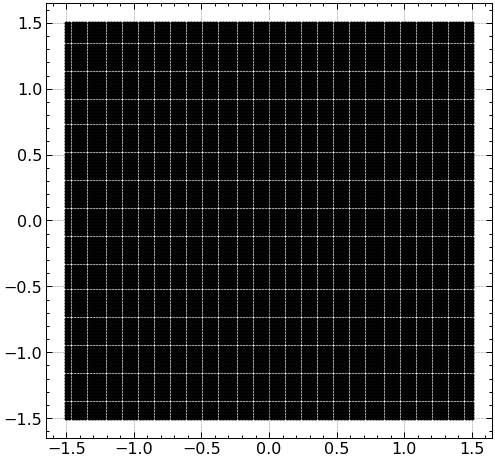

In [4]:
plt.figure(figsize=(8,8))
plt.plot(k_spacex, k_spacey, marker='.', color='k', linestyle='none')

plt.show()

![](ham.PNG)

![](k.PNG)

Note: $m\rightarrow \inf$


![](dispersion.PNG)

In [5]:
σx = np.array([[0, 1],[1, 0]]); σy = np.array([[0, -1j],[1j, 0]]); σz = np.array([[1, 0],[0, -1]])
def ϵplus(k):
    k_x, k_y = k
    return np.sqrt(v**2*(k_x**2+k_y**2)+λ**2/4*np.abs((k_y+1j*k_x)**3+(k_y-1j*k_x)**3)**2)

def H(k, p = np.array([1, 0.25, 0.25])):
    k_x, k_y = k
    b, v, λ = p
    kp = k_y+1j*k_x; km = k_y-1j*k_x
    return v*(k_x*σy-k_y*σx)+λ/2*(kp**3+km**3)*σz

def H0(k, p = np.array([1, 0.25, 0.25])):
    k_x, k_y = k
    b, v, λ = p
    kp = k_y+1j*k_x; km = k_y-1j*k_x
    return v*(k_x*σy-k_y*σx)

print(ϵplus([0.2,1.1]))
print(H([0.2,1.1]))

0.40984760887432303
[[ 0.29975+0.j   -0.275  -0.05j]
 [-0.275  +0.05j -0.29975+0.j  ]]


In [6]:
from numpy import linalg as LA
def G0(k, ω):
    kx, ky = k
    Ham = H(k); 
    λ, v = LA.eig(Ham)
    summ = np.zeros([2,2])
    for n in range(len(λ)):
        g = (ω+1j*0.01-λ[n])**(-1)
        ψ = v[n]
        summ = summ+g*np.matmul(np.transpose(ψ), np.conj(ψ))
    return summ
print(G0([0.2,1.1], 0.2))       

[[-3.11525273-0.25345302j -3.11525273-0.25345302j]
 [-3.11525273-0.25345302j -3.11525273-0.25345302j]]


In [7]:
k_spacex1, k_spacey1 = np.mgrid[-0.5*np.pi:0.5*np.pi:N*1j,-0.5*np.pi:0.5*np.pi:N*1j]

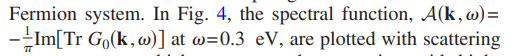

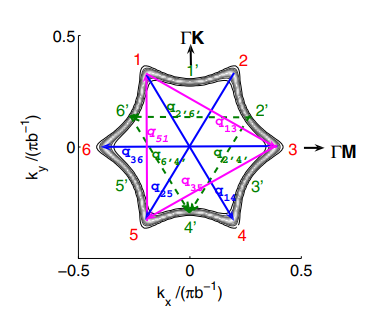

In [8]:
def A(k, ω):
    return -1/np.pi*np.imag(np.trace(G0(k, ω)))

for i in tqdm(range(N), desc="Spectral Function Iterations"):
    for j in range(N):
        var[i, j] = A([k_spacex1[i, j], k_spacey1[i, j]], 0.3)/np.pi
    
        

Spectral Function Iterations: 100%|██████████| 128/128 [00:01<00:00, 68.82it/s]


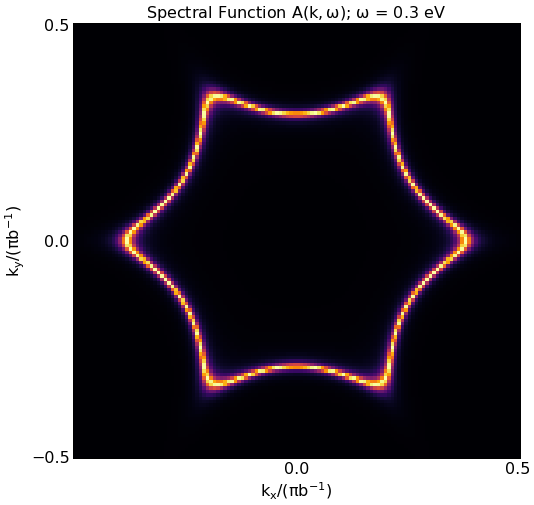

In [9]:
plt.figure(figsize=(8,8))
plt.pcolormesh(k_spacex1/np.pi,k_spacey1/np.pi, var, shading = 'auto', cmap = 'inferno')
plt.title("Spectral Function $A(k, ω)$; ω = 0.3 eV")
plt.xlabel('$k_x/(πb^{-1})$')
plt.ylabel('$k_y/(πb^{-1})$')
plt.yticks([-0.5, 0, 0.5])
plt.xticks([0, 0.5])

plt.show()

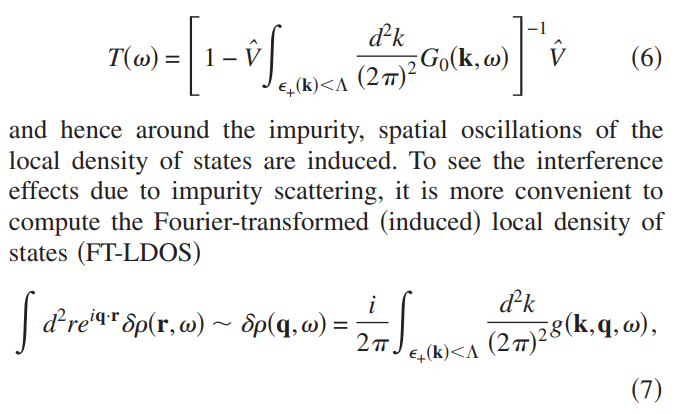

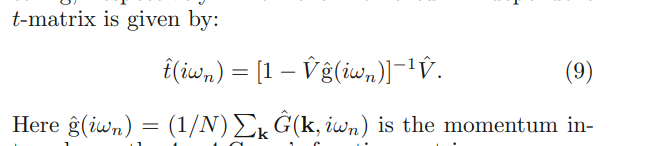



In [10]:
k_spacex3, k_spacey3 = np.mgrid[-np.pi:np.pi:N*1j,-np.pi:np.pi:N*1j]

In [11]:
V = 0.05/len(k_spacex)*np.eye(2)

In [12]:
from numpy.linalg import inv
def T(ω):
    summm = np.zeros([2,2])
    for i in tqdm(range(N), desc="T-Matrix"):
        for j in range(N):
            summm = summm + G0([k_spacex3[i, j], k_spacey3[i, j]], ω)/N
    return np.matmul(inv(np.eye(2)-np.matmul(V, summm)), V)

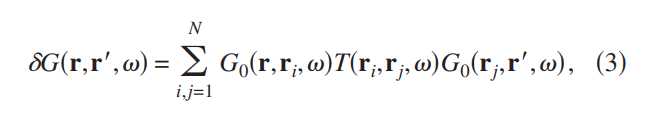
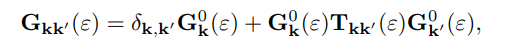

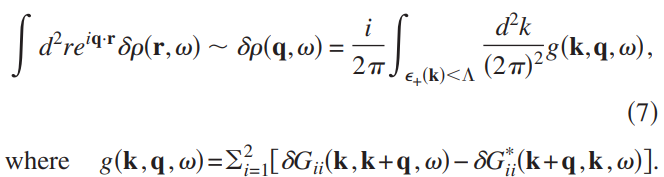

In [13]:
om = 0.3
T1 = T(om) #outside of function speeds up
def G(k, kp, ω = om):
    return np.matmul(np.matmul(G0(k,ω), T1), G0(kp,ω))

T-Matrix: 100%|██████████| 128/128 [00:01<00:00, 101.34it/s]


In [14]:
q_spacex3, q_spacey3 = np.mgrid[-np.pi:np.pi:Nq*1j,-np.pi:np.pi:Nq*1j]


In [15]:
def DOS(q, ω = om):
    #G1 = G(k, k+q)
    #G2 = (-1*G(k+q, k)).getH()
    qx, qy = q
    summ = 0+0*1j
    for i in range(N):
        for j in range(N):
            k = np.array([k_spacex3[i, j], k_spacey3[i, j]])
            G1 = np.trace(G(k, k+q))
            G2 = -1*np.trace(G(k+q, k).conj().T)
            summ = summ+G1+G2
    return np.real(1j*summ/(2*np.pi)**3)
#go = DOS(np.array([0,1]))
print(DOS(np.array([0,1])))

0.8192919205829705


In [16]:
sol = np.zeros((Nq,Nq))
qf = np.array([q_spacex3, q_spacey3])

In [17]:
for i in tqdm(range(Nq), desc="DOS"):
        for j in range(Nq):
            #var[i, j] = A([k_spacex1[i, j], k_spacey1[i, j]], 0.3)/np.pi
            sol[i, j] = DOS(qf[:,i, j])

DOS: 100%|██████████| 64/64 [6:36:34<00:00, 371.78s/it]  


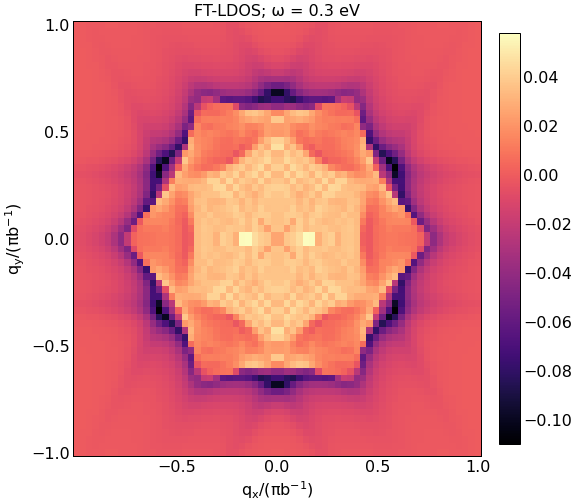

In [22]:
plt.figure(figsize=(8,8))
plt.pcolormesh(q_spacex3/np.pi,q_spacey3/np.pi, sol/20, cmap = "magma", shading = 'auto')
plt.title("FT-LDOS; ω = 0.3 eV")
plt.xlabel('$q_x/(πb^{-1})$')
plt.ylabel('$q_y/(πb^{-1})$')
plt.yticks([-1, -0.5 ,0, 0.5, 1])
plt.xticks([ -0.5 ,0, 0.5, 1])
plt.colorbar(fraction=0.046, pad=0.04)
plt.savefig('QPI 12864', bbox_inches='tight')
plt.show()

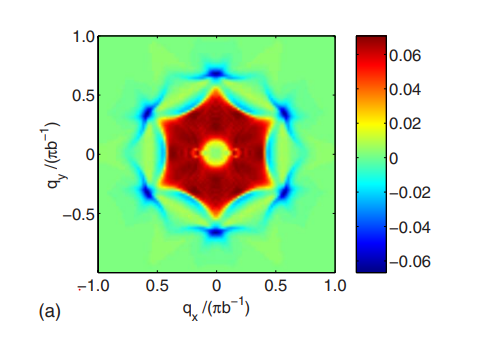

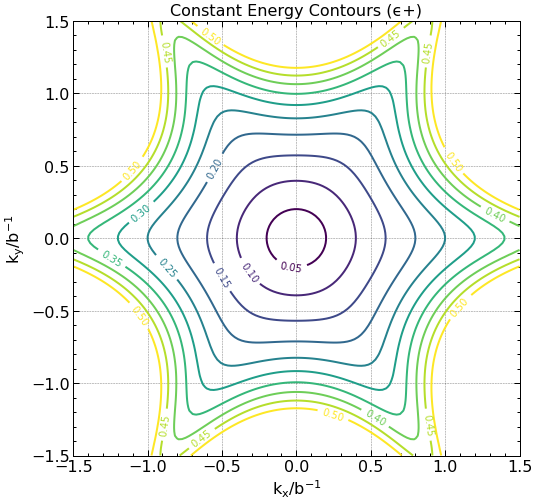

In [19]:
plt.figure(figsize=(8,8))
CS = plt.contour(k_spacex,k_spacey, ϵplus([k_spacex, k_spacey]), levels = [0.05, 0.05*2, 0.05*3, 0.05*4, 0.05*5, 0.3, 0.35, 0.4, 0.45, 0.5] )
plt.clabel(CS, inline=1, fontsize=10)
plt.title('Constant Energy Contours (ϵ+)')
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)
#labels = ['ω = 0.05','ω =0.3']
# for i in range(len(labels)):
#     CS.collections[i].set_label(labels[i])
plt.xlabel('$k_x/b^{-1}$')
plt.ylabel('$k_y/b^{-1}$')

plt.show()

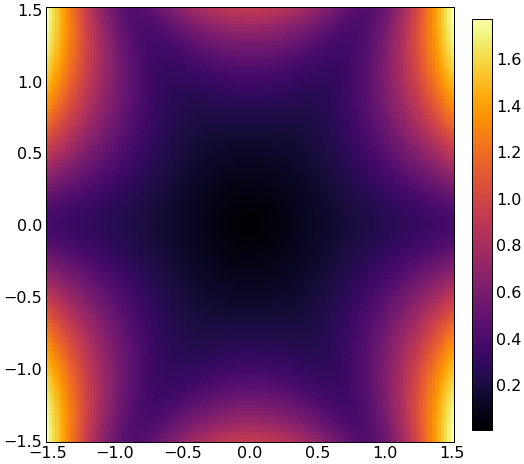

In [21]:
plt.figure(figsize=(8,8))
plt.pcolormesh(k_spacex,k_spacey, ϵplus([k_spacex, k_spacey]), shading = 'auto', cmap = 'inferno')
plt.colorbar(fraction=0.046, pad=0.04)
plt.show()